In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [3]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,-0.357917,-6.289483,-7.573329,-3.273109,-0.047841,9.462104
1,-3.835415,0.232564,15.567179,5.952334,-1.411911,-4.395430
2,-4.000293,-5.686593,-9.716810,-6.585641,7.205666,5.940221
3,-0.476328,16.827456,-0.997094,-4.125641,-3.252111,-1.890935
4,-0.033632,-1.931396,1.993589,14.743385,-6.337326,-0.032644


In [4]:
# min-max normalization
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [5]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.193130,0.034364,0.000000,0.115101,0.201430,0.455976,0.455976,5,Walking,Walking
1,0.014553,0.120264,0.518753,0.268900,0.077530,0.000000,0.518753,2,Sitting,Sitting
2,0.125755,0.088659,0.000000,0.068881,0.372271,0.344433,0.372271,4,Upstairs,Upstairs
3,0.118334,0.679431,0.101447,0.000000,0.028325,0.072463,0.679431,1,Jogging,Jogging
4,0.135780,0.094902,0.179445,0.454072,0.000000,0.135801,0.454072,3,Standing,Standing
5,0.011341,0.144567,0.000000,0.068585,0.181904,0.593603,0.593603,5,Walking,Walking
6,0.383751,0.061330,0.000000,0.079424,0.256058,0.219437,0.383751,0,Downstairs,Downstairs
7,0.391704,0.003480,0.000000,0.046713,0.314391,0.243713,0.391704,0,Downstairs,Downstairs
8,0.151160,0.416085,0.138929,0.092031,0.000000,0.201795,0.416085,1,Jogging,Jogging
9,0.189489,0.098559,0.000000,0.074315,0.090923,0.546714,0.546714,5,Walking,Walking


Accuracy:  0.9507102100279228


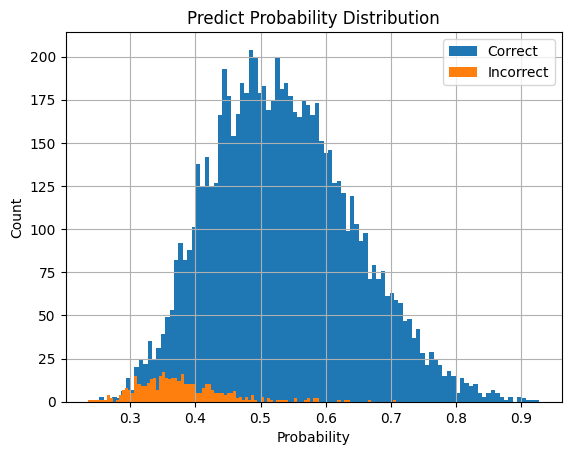

In [6]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [7]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.526993
std       0.111614
min       0.235825
max       0.927062
median    0.521415
Name: predict_probability, dtype: float64

In [9]:
thresholds = [0, 0.3, 0.4, 0.5, 0.6, 0.7]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_labels = LABELS[:len(cm)]
    cm_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    if threshold == 0:
        plt.savefig(f'confusion_matrix/original.png')
    else:
        plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_10809/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.950710,1.000000,0.000000,0.000000
0.3,0.954718,0.991987,0.454545,0.008013
0.4,0.983164,0.872526,0.728571,0.127474
0.5,0.994869,0.567804,0.892697,0.432196
0.6,0.997602,0.253126,0.934818,0.746874
0.7,0.998305,0.071628,0.947038,0.928372
